In [21]:
# Importing the libraries

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
from io import BytesIO
import pycountry
import plotly.express as px
from scipy.stats import normaltest

In [2]:
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/EI_ISBU_Q?format=TSV&compressed=true' # The url of the data
headers = {'Accept-Encoding': 'gzip'} # This is important to get the gzip file
response = requests.get(url, headers=headers) # Get the data from the url

buf = BytesIO(response.content) # Read the gzip file
f = gzip.GzipFile(fileobj=buf) # Unzip the gzip file
content = f.read() # Read the unzipped file

df = pd.read_csv(BytesIO(content), sep='\t') # Read the unzipped file as a dataframe
print(df.head())


  freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD 1980-Q1  1980-Q2  1980-Q3   \
0                       Q,I2015,NSA,IS-EPI,F,AL       :        :        :    
1                       Q,I2015,NSA,IS-EPI,F,AT       :        :        :    
2                       Q,I2015,NSA,IS-EPI,F,BE       :        :        :    
3                       Q,I2015,NSA,IS-EPI,F,BG       :        :        :    
4                       Q,I2015,NSA,IS-EPI,F,CH       :        :        :    

  1980-Q4  1981-Q1  1981-Q2  1981-Q3  1981-Q4  1982-Q1   ... 2020-Q4   \
0       :        :        :        :        :        :   ...   119.4    
1       :        :        :        :        :        :   ...   116.9    
2       :        :        :        :        :        :   ...   108.2    
3       :        :        :        :        :        :   ...   103.3    
4       :        :        :        :        :        :   ...  102.1 e   

  2021-Q1  2021-Q2  2021-Q3  2021-Q4  2022-Q1  2022-Q2  2022-Q3  2022-Q4   \
0   123.7    12

In [3]:
# Melt the dataframe so all the Quarters are in one column
df = pd.melt(df, id_vars=['freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD'], var_name='Quarter', value_name='Value')

# The column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD is split into 6 columns
df[['freq','unit','s_adj','indic','nace_r2','geo\TIME_PERIOD']] = df['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Drop the column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD and move Quarter and Value to the back
df = df.drop(['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'], axis=1)
df = df[['freq', 'unit', 's_adj', 'indic', 'nace_r2','geo\TIME_PERIOD','Quarter', 'Value']]

# Print the first 5 rows of the dataframe
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,:
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,:
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,:
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,:
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,:


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70930 entries, 0 to 70929
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   freq             70930 non-null  object
 1   unit             70930 non-null  object
 2   s_adj            70930 non-null  object
 3   indic            70930 non-null  object
 4   nace_r2          70930 non-null  object
 5   geo\TIME_PERIOD  70930 non-null  object
 6   Quarter          70930 non-null  object
 7   Value            70930 non-null  object
dtypes: object(8)
memory usage: 4.3+ MB


In [5]:
# set values containing ":" to NaN
df.loc[df['Value'].str.contains(':'), 'Value'] = pd.np.nan

C:\Users\Paul\AppData\Local\Temp\ipykernel_28052\2627470230.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[df['Value'].str.contains(':'), 'Value'] = pd.np.nan


In [6]:
# if the Value column has an alphabetical character remove it
df['Value'] = df['Value'].str.replace('[a-zA-Z]', '')

C:\Users\Paul\AppData\Local\Temp\ipykernel_28052\2254030720.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Value'] = df['Value'].str.replace('[a-zA-Z]', '')


In [7]:
#Convert the Value column to a float
df['Value'] = df['Value'].astype(float)

In [8]:
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,NaN
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,NaN
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,NaN
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,NaN
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,NaN


In [30]:
countrycode_map = {c.alpha_2: c.alpha_3 for c in pycountry.countries} # Create a dictionary of country codes

#Uk is not a country code so we will change it to GB
df.loc[df['geo\\TIME_PERIOD'] == 'UK', 'geo\\TIME_PERIOD'] = 'GB'

df['Country_Codes'] = df['geo\\TIME_PERIOD'].map(countrycode_map) # Map the country codes to the dataframe


In [31]:
# Print unique values of the Country_Codes column
print(df['Country_Codes'].unique())

['ALB' 'AUT' 'BEL' 'BGR' 'CHE' 'CYP' 'CZE' 'DEU' 'DNK' nan 'EST' 'ESP'
 'FIN' 'FRA' 'HRV' 'HUN' 'IRL' 'ISL' 'ITA' 'LTU' 'LUX' 'LVA' 'MNE' 'MKD'
 'MLT' 'NLD' 'NOR' 'POL' 'PRT' 'ROU' 'SRB' 'SWE' 'SVN' 'SVK' 'TUR' 'GBR'
 'BIH']


In [32]:
# Create a country plot with the Value column as the color and the Quarter column as the animation, show for indicators '[IS-IP]' and Seasonal Adjustment 'NSA'

fig = px.choropleth(df[(df['indic'] == 'IS-IP') & (df['s_adj'] == 'NSA')], locations="Country_Codes",color="Value", hover_name="geo\TIME_PERIOD", animation_frame="Quarter", color_continuous_scale=px.colors.sequential.Plasma, range_color=(0, 100), scope='europe') # Create the plot

fig.show()

In [33]:
# Seperate the geo\TIME_PERIOD value that equals 'IE' into a seperate dataframe
df_ie = df[df['geo\TIME_PERIOD'] == 'IE']

In [34]:
#Perform EDA on the IE dataframe
df_ie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 20 to 70911
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             1730 non-null   object 
 1   unit             1730 non-null   object 
 2   s_adj            1730 non-null   object 
 3   indic            1730 non-null   object 
 4   nace_r2          1730 non-null   object 
 5   geo\TIME_PERIOD  1730 non-null   object 
 6   Quarter          1730 non-null   object 
 7   Value            924 non-null    float64
 8   Country_Codes    1730 non-null   object 
dtypes: float64(1), object(8)
memory usage: 135.2+ KB


In [35]:
df_ie.describe(include='all')

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value,Country_Codes
count,1730,1730,1730,1730,1730,1730,1730,924.000000,1730
unique,1,1,2,5,2,1,173,NaN,1
top,Q,I2015,NSA,IS-EPI,F,IE,1980-Q1,NaN,IRL
freq,1730,1730,865,346,1384,1730,10,NaN,1730
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.058766,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.922053,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.600000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.025000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.650000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.425000,NaN


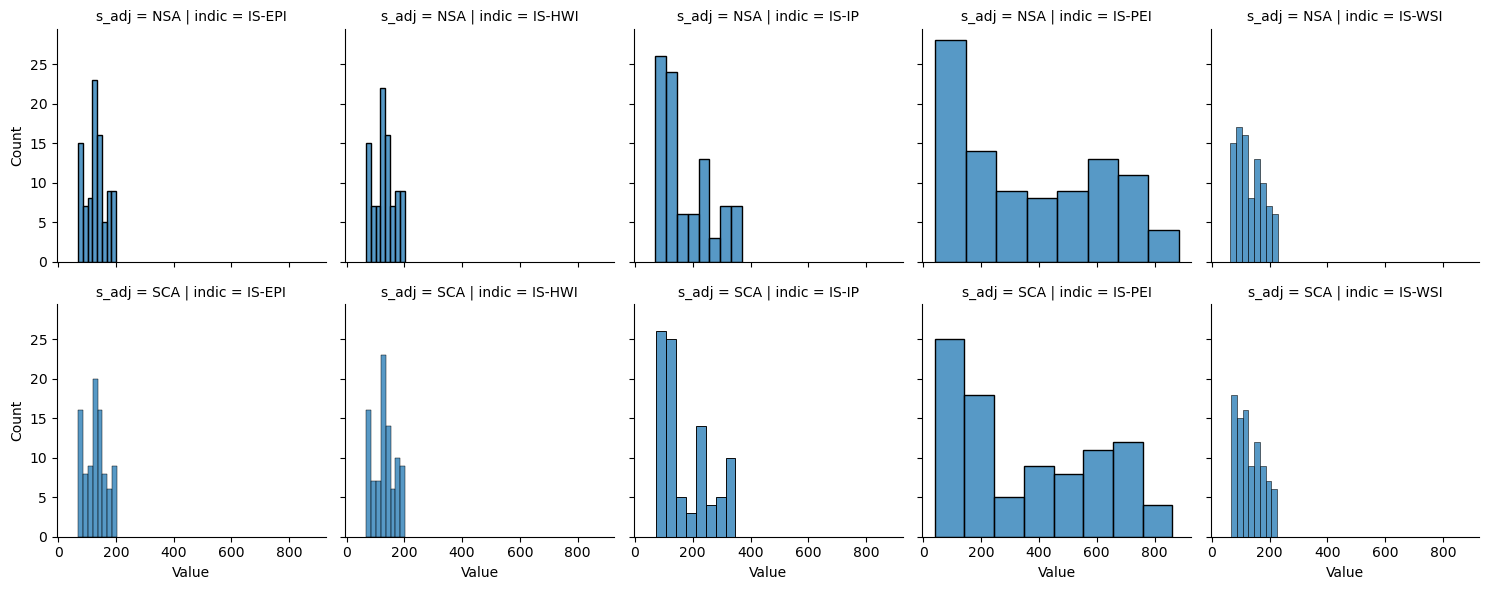

In [38]:
# Use a facet plot to show histograms of the Value column for the IE dataframe grouped by 'indic' and 's_adj', set the maximum x value to 250
sns.FacetGrid(df_ie, col='indic', row='s_adj').map(sns.histplot, 'Value').add_legend()

In [39]:
# Perform Statistical Analysis on the IE dataframe
df_ie.describe(include='all')

df_ie.groupby(['indic','s_adj']).describe()

Value                                                          \
             count        mean         std   min      25%     50%      75%   
indic  s_adj                                                                 
IS-EPI NSA    92.0  131.552174   36.385586  69.0  102.400  130.85  151.700   
       SCA    92.0  131.546739   36.343052  69.9  101.725  131.70  152.250   
IS-HWI NSA    92.0  131.676087   37.511763  66.4  102.725  130.50  156.175   
       SCA    92.0  131.770652   37.393220  68.3  102.900  131.10  156.150   
IS-IP  NSA    92.0  173.594565   86.308337  69.3  100.025  140.00  230.650   
       SCA    92.0  172.402174   84.990736  73.0  101.425  138.45  227.425   
IS-PEI NSA    96.0  368.627083  251.512695  41.6  135.650  345.35  613.000   
       SCA    92.0  359.218478  251.423689  38.6  131.775  305.50  578.700   
IS-WSI NSA    92.0  131.308696   44.575247  62.3   95.300  122.90  165.225   
       SCA    92.0  130.996739   44.098567  67.1   94.600  121.80  164.725   

                     
                max  
indic  s_adj         
IS-EPI NSA    201.4  
       SCA    203.6  
IS-HWI NSA    202.5  
       SCA    203.0  
IS-IP  NSA    371.0  
       SCA    347.6  
IS-PEI NSA    883.7  
       SCA    861.8  
IS-WSI NSA    227.2  
       SCA    225.1

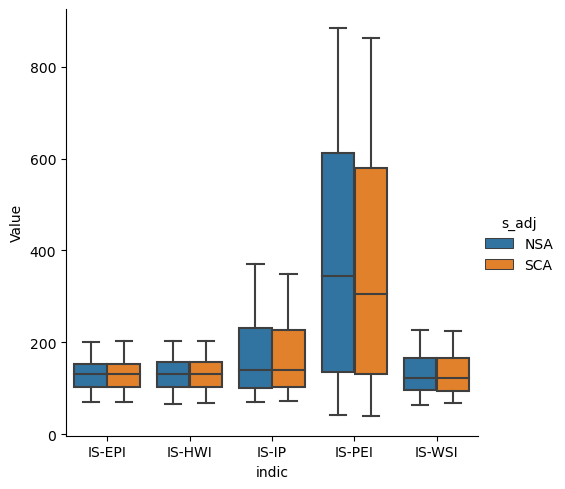

In [40]:
# Visualise the IE dataframe showing statistical analysis using seaborn  and matplotlib  libraries splitting the data by insdicators and seasonanal adjustment
sns.catplot(x="indic", y="Value", hue="s_adj", kind="box", data=df_ie);

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70930 entries, 0 to 70929
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             70930 non-null  object 
 1   unit             70930 non-null  object 
 2   s_adj            70930 non-null  object 
 3   indic            70930 non-null  object 
 4   nace_r2          70930 non-null  object 
 5   geo\TIME_PERIOD  70930 non-null  object 
 6   Quarter          70930 non-null  object 
 7   Value            38008 non-null  float64
 8   Country_Codes    62799 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.9+ MB


In [101]:
df.set_index(['geo\\TIME_PERIOD', 'indic', 's_adj'], inplace=True)

# Perform normality test on the Value column grouped by geo\TIME_PERIOD, indic, and s_adj
grouped = df.groupby(['geo\\TIME_PERIOD', 'indic', 's_adj'])['Value']
pvalues = grouped.apply(lambda x: normaltest(x.dropna())[1])

# Add p-values to a new column in the original DataFrame
df.loc[pvalues.index, 'pvalue'] = pvalues

#Add a new column to the dfi dataframe called 'normal' and set it to True if the pvalue is greater than 0.05 and False if it is less than 0.05
df['normal'] = dfi['pvalue'] > 0.05

# Move the index back to columns
df.reset_index(inplace=True)